Adaptive NVAR Model \
Author: Azimov Sherkhon \
Email: sherxonazimov94@pusan.ac.kr \
Date: May 2025 \
Description: a jointly trained adaptive NVAR model that combines delay-
embedded linear inputs with features generated by a shallow, learnable Multi-Layer Perceptron
(MLP). We employ a unified training strategy where both the MLP and linear readout are optimized
simultaneously using gradient-based methods.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split
torch.set_default_dtype(torch.float64)

import warnings
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.current_device()} - {torch.cuda.get_device_name(0)}")

Device in use: cuda
CUDA device: 0 - NVIDIA GeForce RTX 3060


In [2]:
# ---------------------------
# Configuration
# ---------------------------
dt = 0.025
maxtime = 100

maxtime_pts = int(maxtime / dt)  # 400 steps of 0.25
t_eval = np.linspace(0, maxtime, maxtime_pts + 1)  # 401 time points

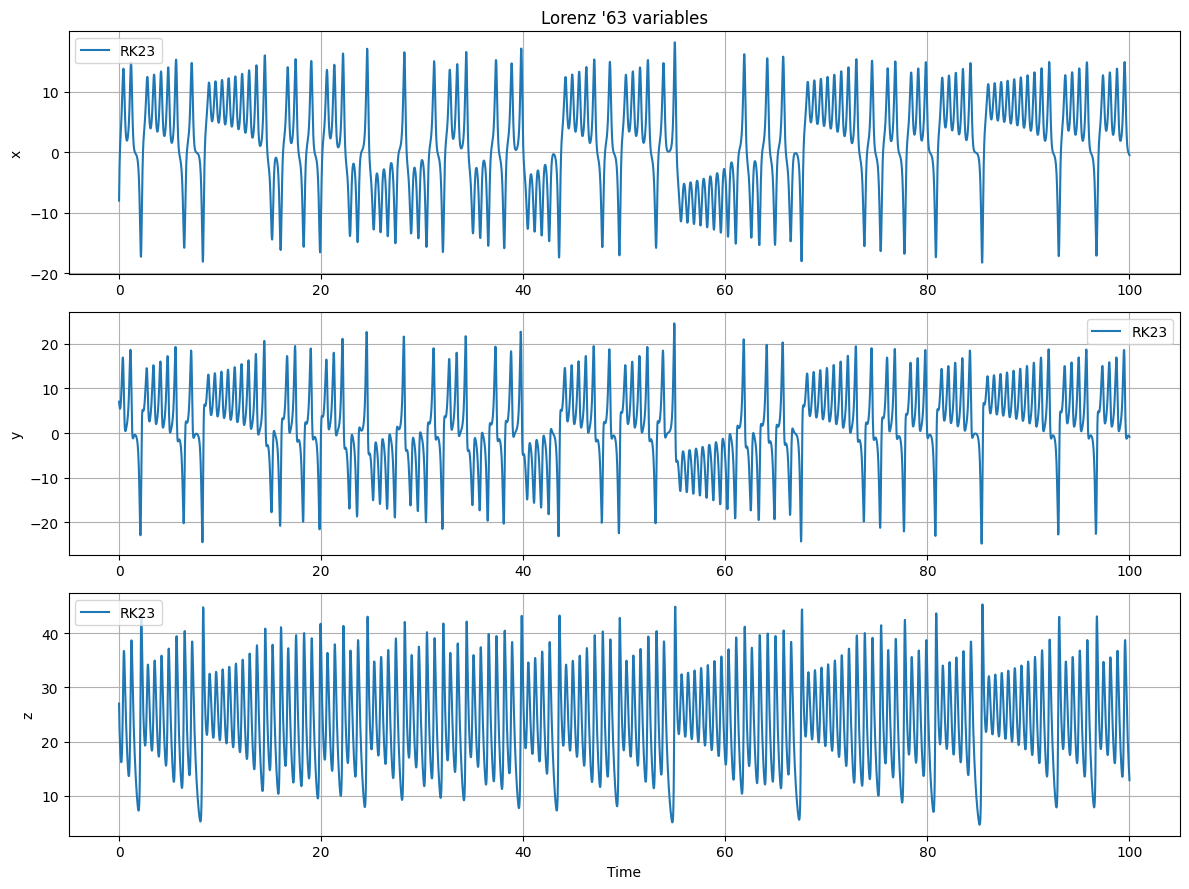

In [3]:
# ---------------------------
# Lorenz '63 System
# ---------------------------
lorenz_rk23 = np.load("ground_truth.npy")
Lorenz63data = lorenz_rk23.T

# ---------------------------
# Visualization
# ---------------------------
variables = ['x', 'y', 'z']
plt.figure(figsize=(12, 9))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(t_eval, lorenz_rk23[i], label='RK23', color='C0')
    plt.ylabel(variables[i])
    plt.grid(True)
    if i == 0:
        plt.title("Lorenz '63 variables")
    if i == 2:
        plt.xlabel('Time')
    plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# Set seeds
seed = 2025
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ---------------------------
# Noise Addition
# ---------------------------
def add_relative_gaussian_noise(X_clean, noise_scale):
    signal_std = np.std(X_clean, axis=0)
    noise = np.random.normal(loc=0.0, scale=noise_scale * signal_std, size=X_clean.shape)
    return X_clean + noise

X_noisy = add_relative_gaussian_noise(Lorenz63data, noise_scale=0.0) # Moderate case: 10% noise
X = torch.tensor(X_noisy, dtype=torch.float64)
X_true = torch.tensor(Lorenz63data, dtype=torch.float64)


In [5]:
# ---------------------------
# Dataset Splitting
# ---------------------------
T_total = X.shape[0]
warmup_len = 200
train_len = 1600
test_len = 200

X_warmup = X[:warmup_len].to(device)
X_train = X[warmup_len:warmup_len + train_len].to(device)
X_test = X[warmup_len + train_len:warmup_len + train_len + test_len].to(device)
X_test_true = X_true[warmup_len + train_len:warmup_len + train_len + test_len].to(device)

In [6]:
# ---------------------------
# Model Definitions
# ---------------------------
d = 3
k = 2
dk = d * k
m = int((dk * (dk + 1)) / 2)

class FeatureMLP(nn.Module):
    def __init__(self, input_dimension=dk, hidden_dimension=2000, output_dimension=m):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dimension, hidden_dimension),
            nn.Tanh(),
            #nn.Dropout(0.10), # No dropouts in noise free case
            nn.Linear(hidden_dimension, output_dimension)
        )

    def forward(self, x):
        return self.net(x)

class AdaptiveNVARModel(nn.Module):
    def __init__(self, dk, m, d):
        super().__init__()
        self.mlp = FeatureMLP(input_dimension=dk, output_dimension=m)
        self.readout = nn.Linear(dk + m, d, bias=False)

    def forward(self, H_lin):
        H_nn = self.mlp(H_lin)
        H_total = torch.cat([H_lin, H_nn], dim=1)
        return self.readout(H_total)

In [7]:
# ---------------------------
# Delay Embedding
# ---------------------------
def construct_H_lin(X, k):
    T = X.shape[0]
    return torch.cat([X[i:T - k + i] for i in range(k)], dim=1)

# ---------------------------
# Training Loop
# ---------------------------
def train_joint_model_with_lbfgs(X, k, m, num_epochs_adam=2000, num_epochs_lbfgs=5000,
                                 save_path="best_joint_model_0percent_noise.pth",  patience=50, tolerance=1e-20):
    X = X.to(device)
    H_lin = construct_H_lin(X, k)                 # [n, dk]
    Y = X[k:] - X[k - 1:-1]                       # [n, d]
    n, dk = H_lin.shape
    d = Y.shape[1]

    model = AdaptiveNVARModel(dk=dk, m=m, d=d).to(device)

    # --- Phase 1: Train with Adam
    optimizer = torch.optim.Adam(model.parameters(),
    lr=0.01,
    betas=(0.9, 0.999),
    eps=1e-10,
    weight_decay=0,
    amsgrad=False,
    foreach=None,
    capturable=False,
    differentiable=False,
    fused=None
     )

    for epoch in range(num_epochs_adam):
        model.train()
        Y_hat = model(H_lin)
        loss = F.mse_loss(Y_hat, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0 or epoch == num_epochs_adam - 1:
            print(f"[Adam] Epoch {epoch:3d} | Loss: {loss.item():.4e}")

    # Save Adam-trained model state before L-BFGS
    torch.save(model.state_dict(), save_path)

    # --- Phase 2: Fine-tune with L-BFGS
    model.load_state_dict(torch.load(save_path))
    optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=20,
    max_eval=None,
    tolerance_grad=1e-10,
    tolerance_change=1e-10,
    history_size=100,
    line_search_fn=None
     )

    best_loss = float('inf')
    epochs_no_improve = 0

    def closure():
        optimizer.zero_grad()
        Y_hat = model(H_lin)
        loss = F.mse_loss(Y_hat, Y)
        loss.backward()
        return loss

    for epoch in range(num_epochs_lbfgs):
        model.train()
        loss = optimizer.step(closure)
        current_loss = loss.item()

        if epoch % 100 == 0 or epoch == num_epochs_lbfgs - 1:
            print(f"[L-BFGS] Epoch {epoch:3d} | Loss: {current_loss:.4e}")

        # Early stopping logic
        if best_loss - current_loss > tolerance:
            best_loss = current_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    # Save final model
    torch.save(model.state_dict(), save_path)
    print("Final model saved after L-BFGS fine-tuning.")
    return model

[Adam] Epoch   0 | Loss: 2.4476e+01
[Adam] Epoch 1000 | Loss: 1.0790e-03
[Adam] Epoch 1999 | Loss: 2.0798e-04
[L-BFGS] Epoch   0 | Loss: 2.0692e-04
[L-BFGS] Epoch 100 | Loss: 3.3799e-06
Early stopping triggered at epoch 147
Final model saved after L-BFGS fine-tuning.


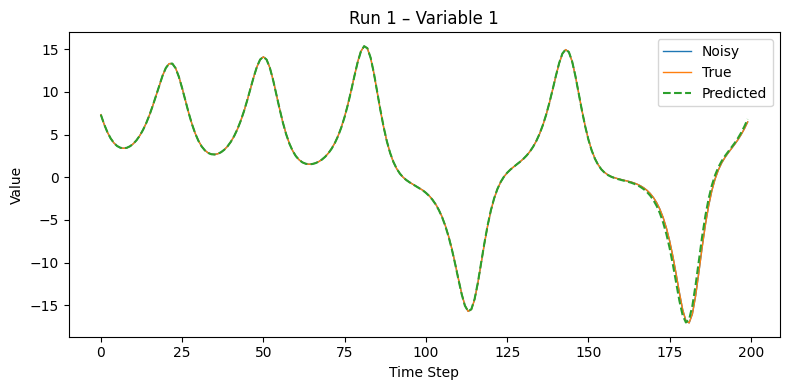

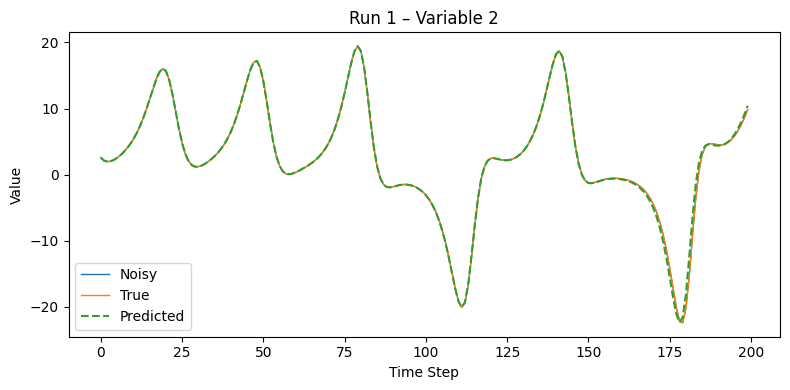

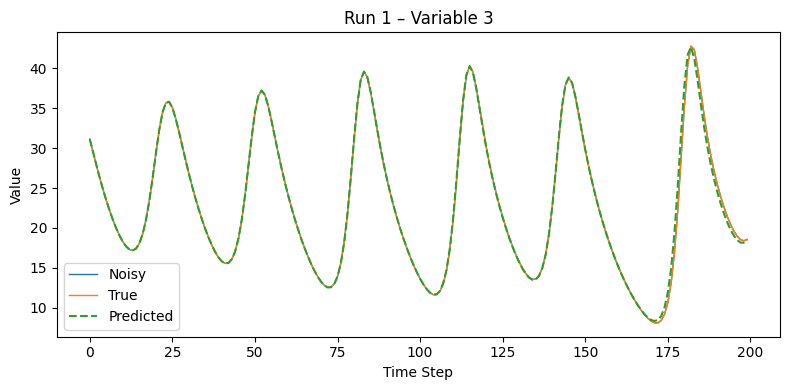

[Adam] Epoch   0 | Loss: 1.0768e+01
[Adam] Epoch 1000 | Loss: 1.7194e-03
[Adam] Epoch 1999 | Loss: 1.5050e-04
[L-BFGS] Epoch   0 | Loss: 1.5013e-04
[L-BFGS] Epoch 100 | Loss: 4.7634e-06
Early stopping triggered at epoch 184
Final model saved after L-BFGS fine-tuning.


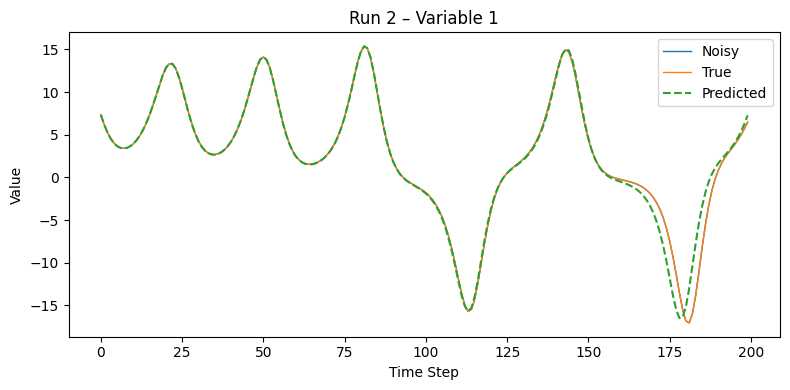

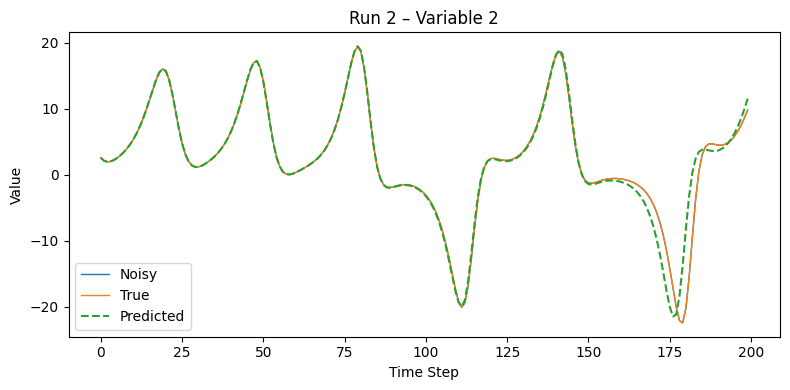

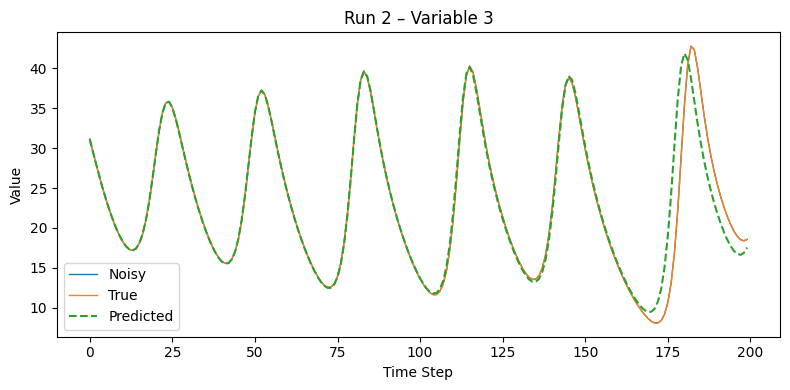

[Adam] Epoch   0 | Loss: 3.0256e+01
[Adam] Epoch 1000 | Loss: 3.6880e-03
[Adam] Epoch 1999 | Loss: 1.9401e-04
[L-BFGS] Epoch   0 | Loss: 1.8875e-04
[L-BFGS] Epoch 100 | Loss: 3.3069e-06
Early stopping triggered at epoch 147
Final model saved after L-BFGS fine-tuning.


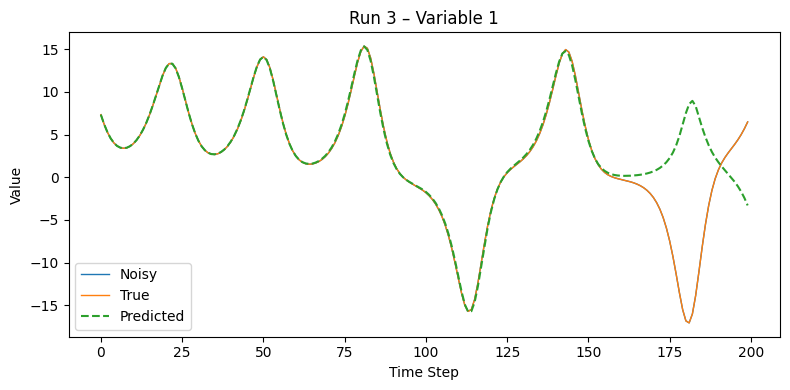

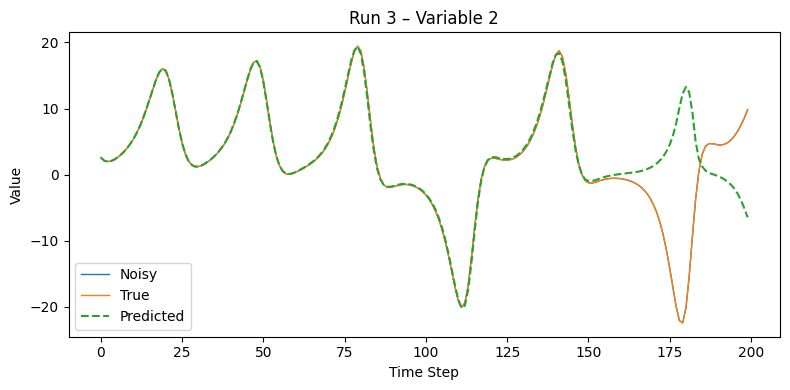

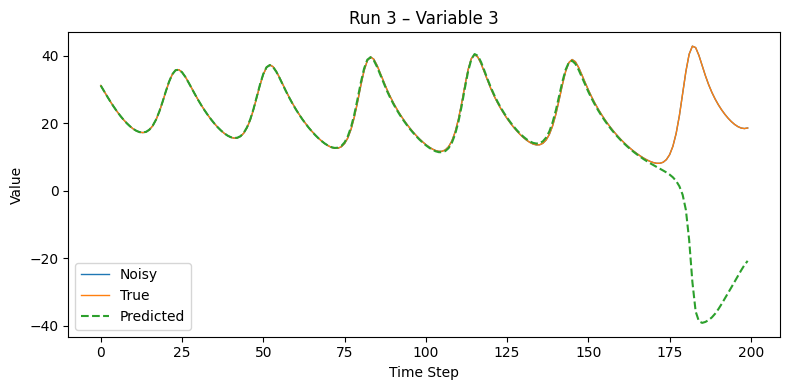

[Adam] Epoch   0 | Loss: 2.8156e+01
[Adam] Epoch 1000 | Loss: 3.7361e-04
[Adam] Epoch 1999 | Loss: 1.0815e-04
[L-BFGS] Epoch   0 | Loss: 1.0774e-04
[L-BFGS] Epoch 100 | Loss: 3.1796e-06
Early stopping triggered at epoch 147
Final model saved after L-BFGS fine-tuning.


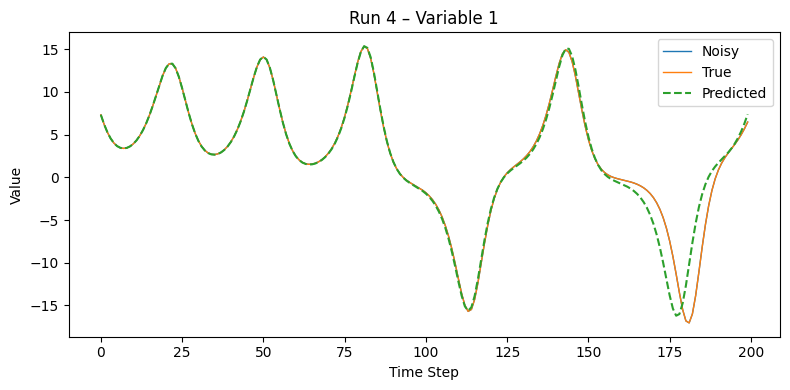

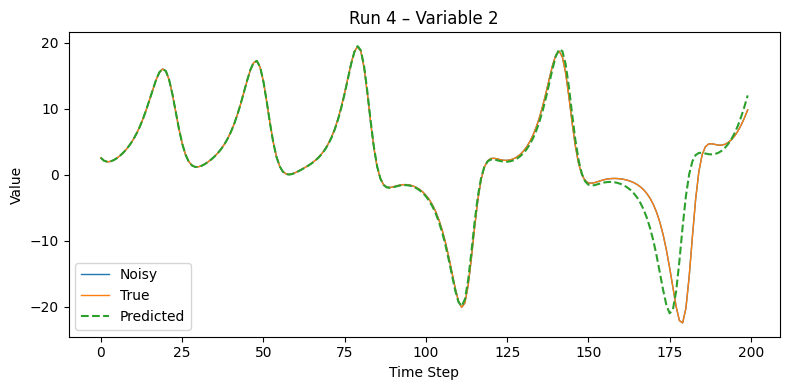

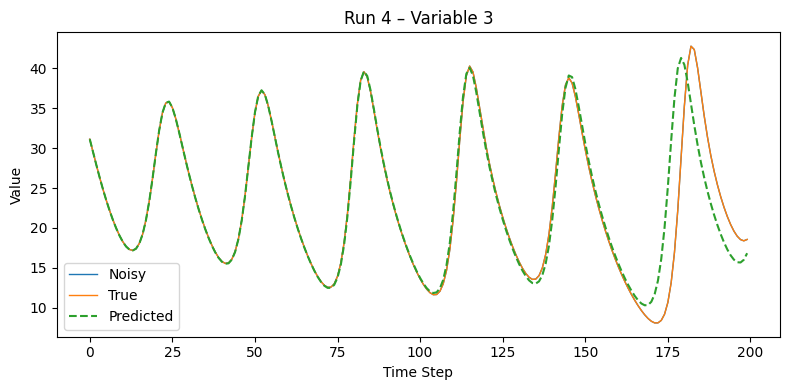

[Adam] Epoch   0 | Loss: 9.3839e+00
[Adam] Epoch 1000 | Loss: 2.7455e-04
[Adam] Epoch 1999 | Loss: 1.8868e-04
[L-BFGS] Epoch   0 | Loss: 1.5730e-04
[L-BFGS] Epoch 100 | Loss: 4.0441e-06
Early stopping triggered at epoch 143
Final model saved after L-BFGS fine-tuning.


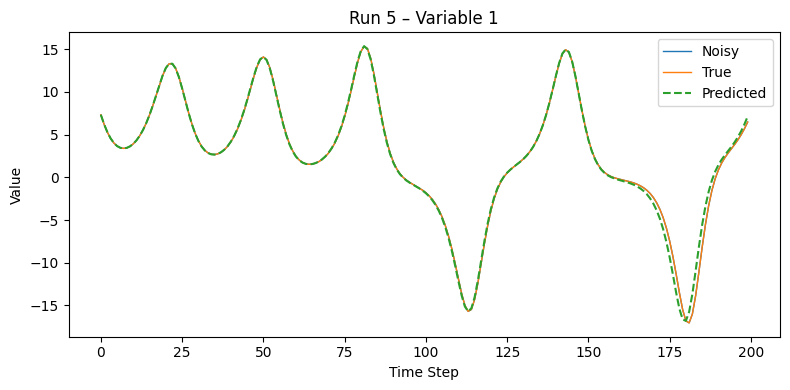

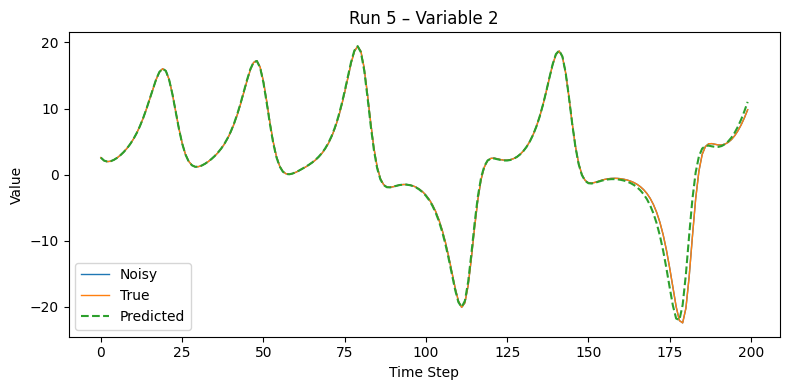

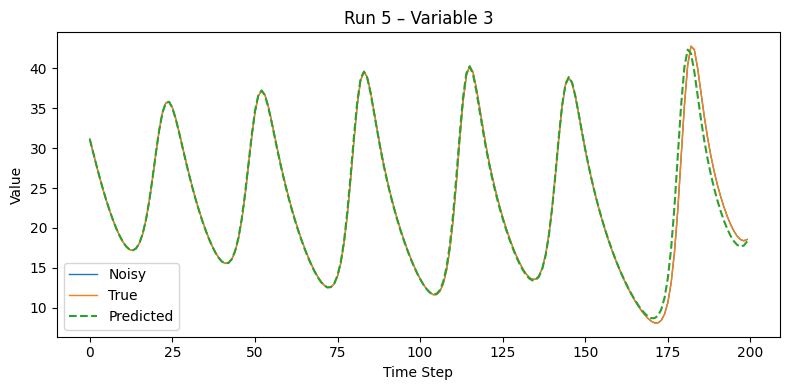

[Adam] Epoch   0 | Loss: 8.4338e+00
[Adam] Epoch 1000 | Loss: 3.8474e-04
[Adam] Epoch 1999 | Loss: 1.1489e-03
[L-BFGS] Epoch   0 | Loss: 5.2242e-04
[L-BFGS] Epoch 100 | Loss: 3.2218e-06
Early stopping triggered at epoch 151
Final model saved after L-BFGS fine-tuning.


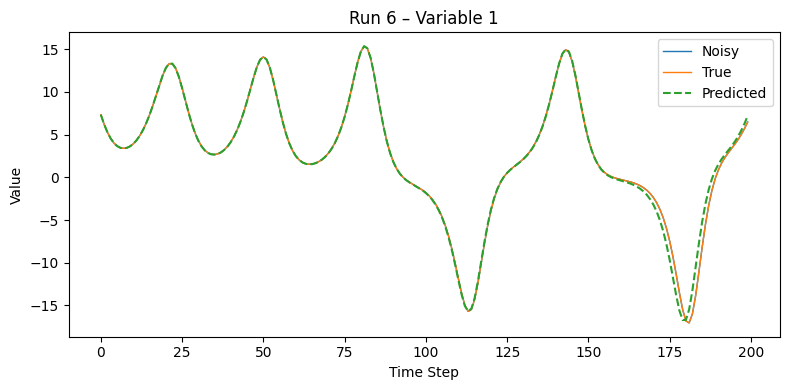

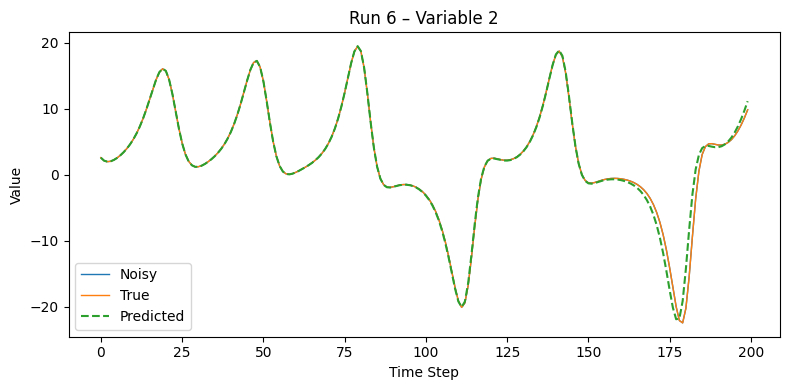

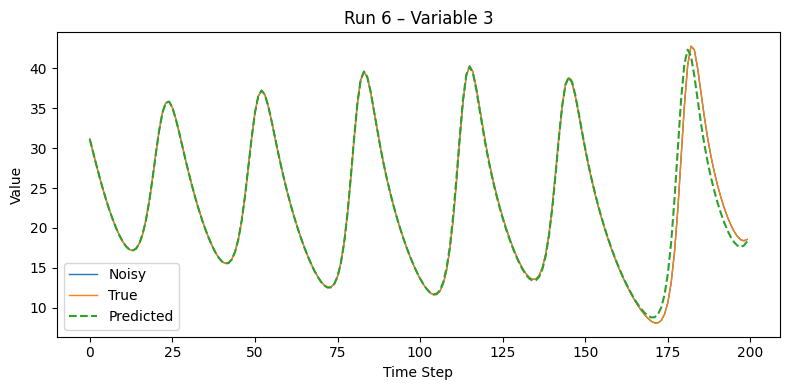

[Adam] Epoch   0 | Loss: 2.6240e+01
[Adam] Epoch 1000 | Loss: 5.0764e-04
[Adam] Epoch 1999 | Loss: 2.0127e-04
[L-BFGS] Epoch   0 | Loss: 1.9844e-04
[L-BFGS] Epoch 100 | Loss: 3.7226e-06
Early stopping triggered at epoch 149
Final model saved after L-BFGS fine-tuning.


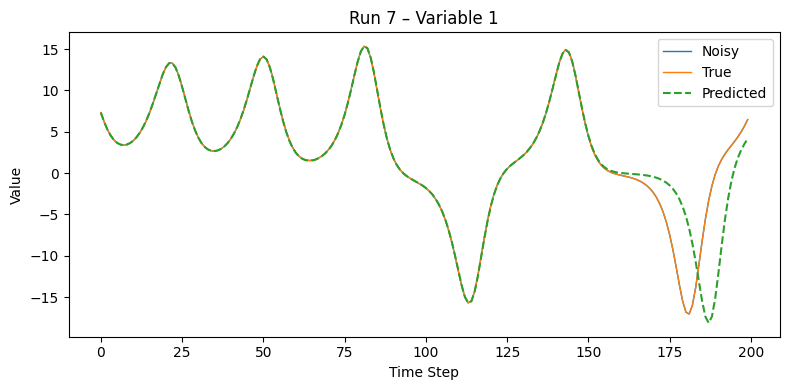

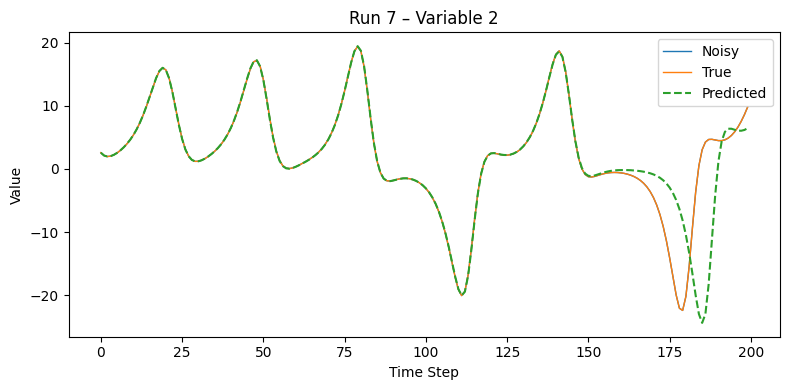

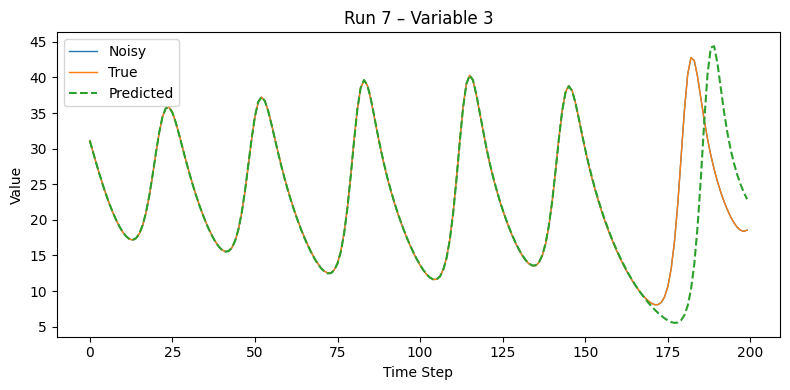

[Adam] Epoch   0 | Loss: 2.0967e+01
[Adam] Epoch 1000 | Loss: 3.1600e-04
[Adam] Epoch 1999 | Loss: 1.0309e-02
[L-BFGS] Epoch   0 | Loss: 3.1423e-02
[L-BFGS] Epoch 100 | Loss: 4.0720e-06
Early stopping triggered at epoch 170
Final model saved after L-BFGS fine-tuning.


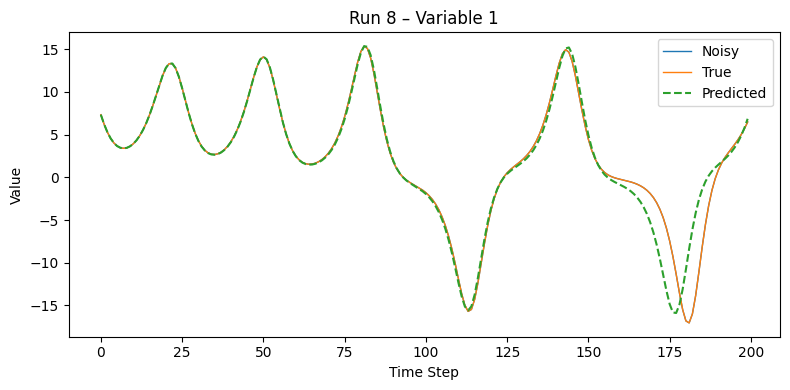

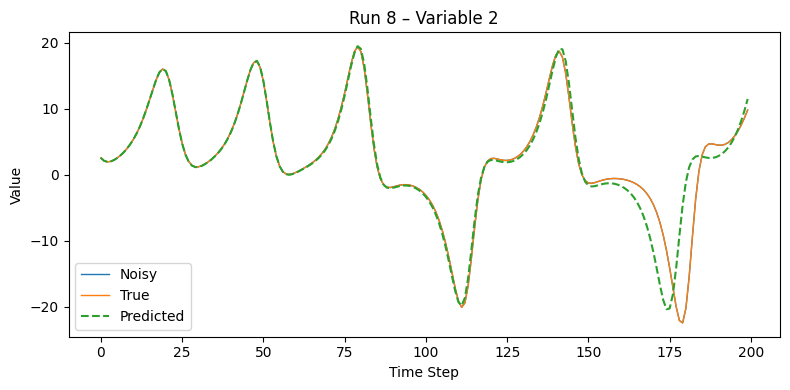

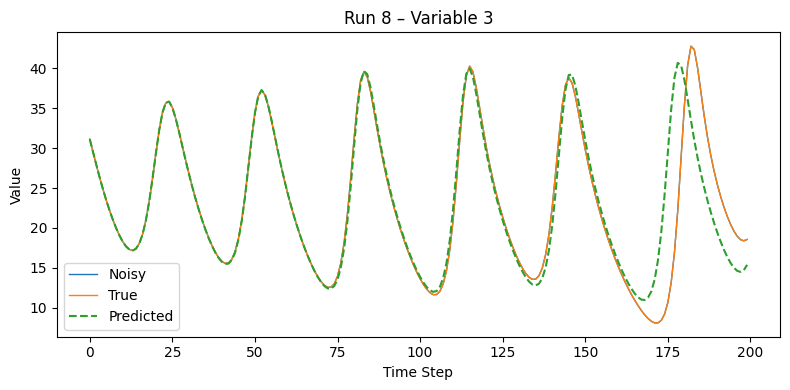

[Adam] Epoch   0 | Loss: 1.9070e+01
[Adam] Epoch 1000 | Loss: 5.8359e-04
[Adam] Epoch 1999 | Loss: 1.2915e-03
[L-BFGS] Epoch   0 | Loss: 2.1552e-03
[L-BFGS] Epoch 100 | Loss: 3.3229e-06
Early stopping triggered at epoch 158
Final model saved after L-BFGS fine-tuning.


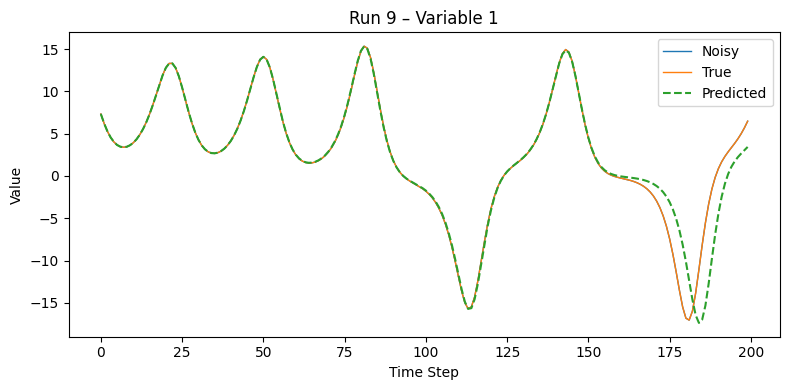

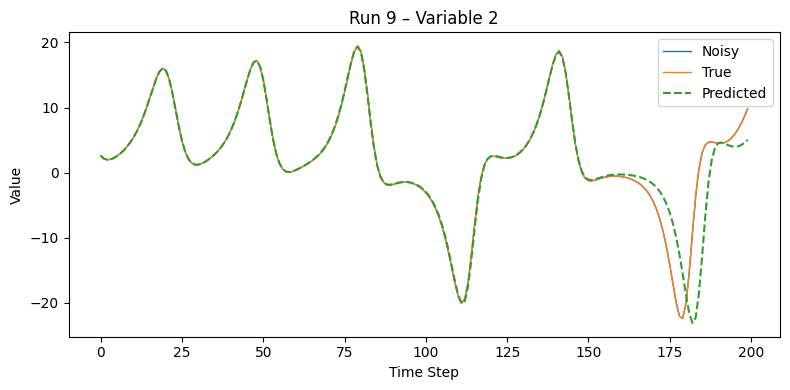

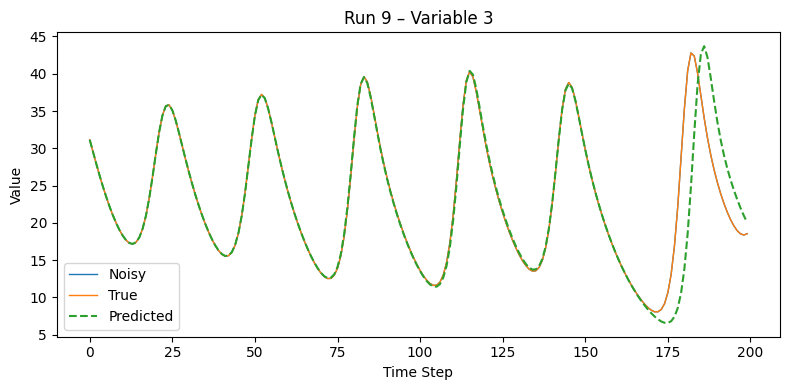

[Adam] Epoch   0 | Loss: 3.1750e+01
[Adam] Epoch 1000 | Loss: 1.6435e-03
[Adam] Epoch 1999 | Loss: 1.9483e-03
[L-BFGS] Epoch   0 | Loss: 1.0014e-03
[L-BFGS] Epoch 100 | Loss: 4.1998e-06
Early stopping triggered at epoch 167
Final model saved after L-BFGS fine-tuning.


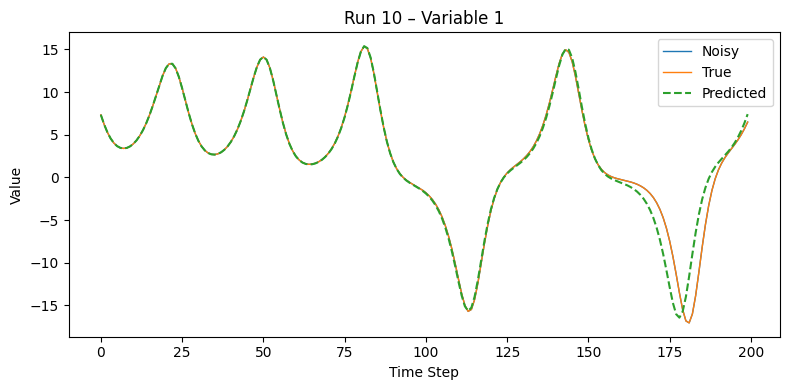

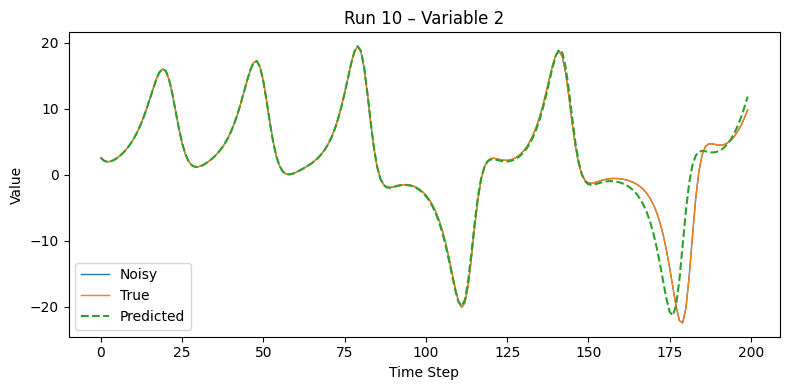

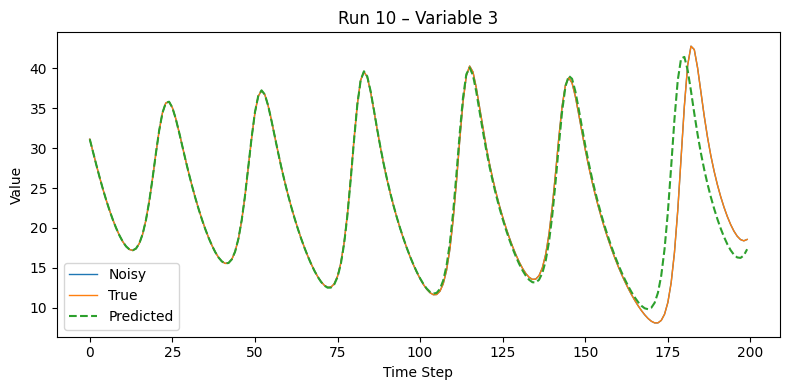

[Adam] Epoch   0 | Loss: 3.4890e+01
[Adam] Epoch 1000 | Loss: 5.6375e-02
[Adam] Epoch 1999 | Loss: 1.3301e-04
[L-BFGS] Epoch   0 | Loss: 1.3236e-04
[L-BFGS] Epoch 100 | Loss: 3.1966e-06
Early stopping triggered at epoch 165
Final model saved after L-BFGS fine-tuning.


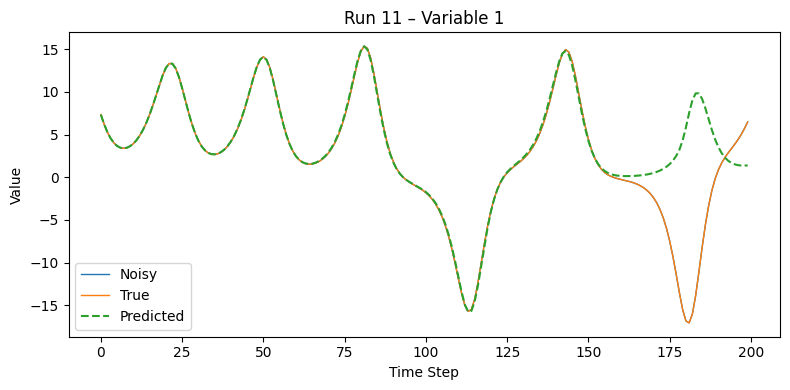

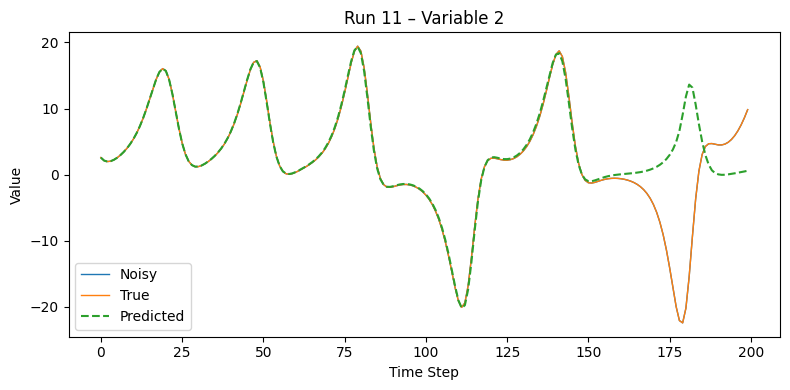

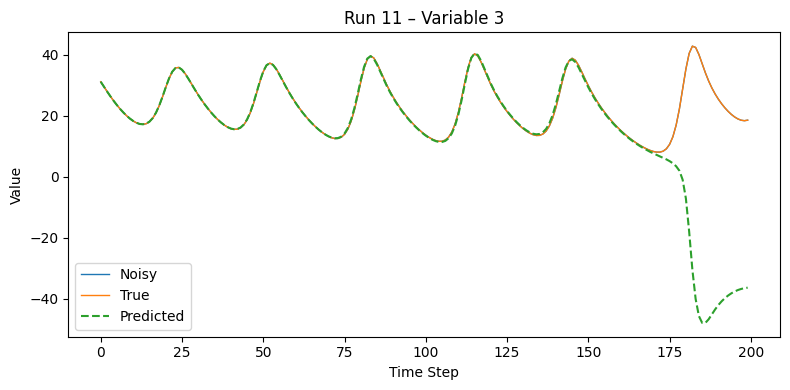

[Adam] Epoch   0 | Loss: 3.3714e+01
[Adam] Epoch 1000 | Loss: 4.8042e-04
[Adam] Epoch 1999 | Loss: 1.2632e-04
[L-BFGS] Epoch   0 | Loss: 1.2593e-04
[L-BFGS] Epoch 100 | Loss: 3.6543e-06
Early stopping triggered at epoch 171
Final model saved after L-BFGS fine-tuning.


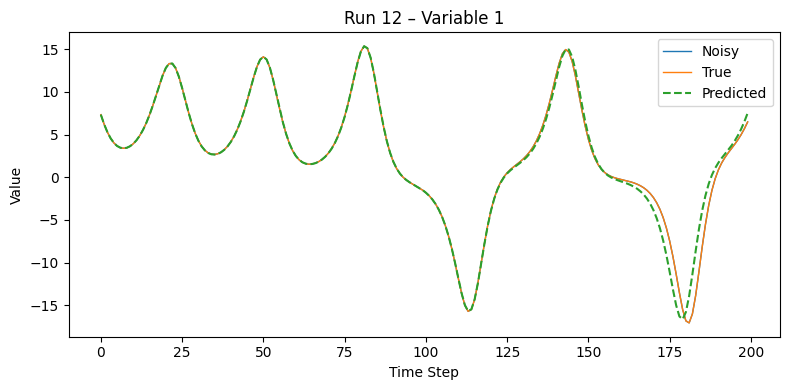

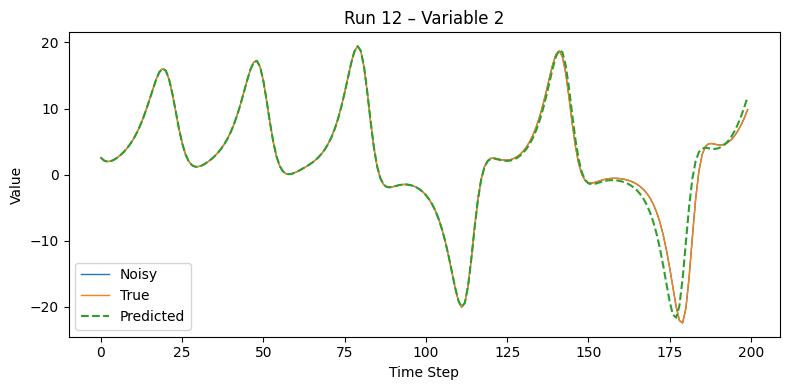

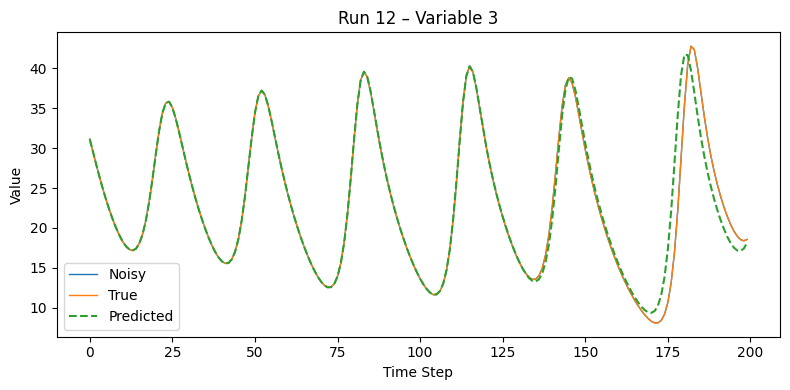

[Adam] Epoch   0 | Loss: 3.4783e+01
[Adam] Epoch 1000 | Loss: 2.2255e-03
[Adam] Epoch 1999 | Loss: 6.2669e-04
[L-BFGS] Epoch   0 | Loss: 2.7995e-03
[L-BFGS] Epoch 100 | Loss: 3.5474e-06
Early stopping triggered at epoch 156
Final model saved after L-BFGS fine-tuning.


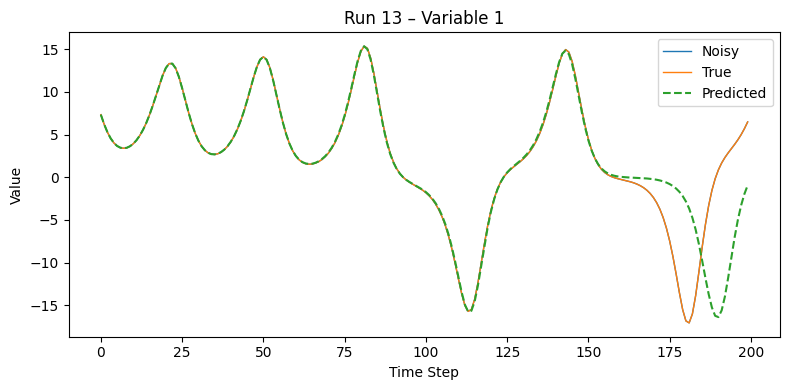

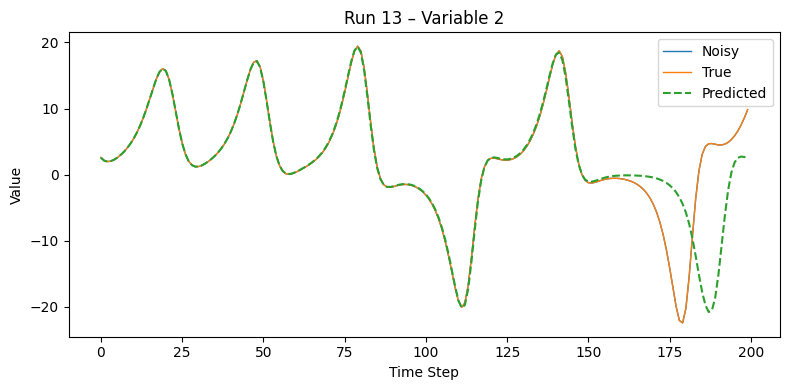

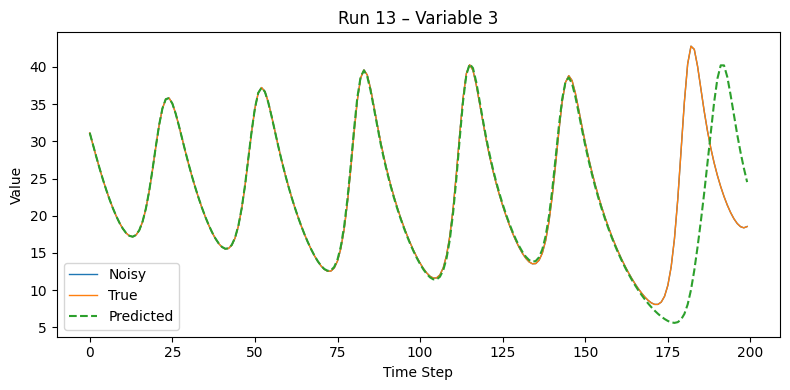

[Adam] Epoch   0 | Loss: 3.7850e+01
[Adam] Epoch 1000 | Loss: 6.8288e-04
[Adam] Epoch 1999 | Loss: 1.5996e-04
[L-BFGS] Epoch   0 | Loss: 1.5882e-04
[L-BFGS] Epoch 100 | Loss: 3.3816e-06
Early stopping triggered at epoch 158
Final model saved after L-BFGS fine-tuning.


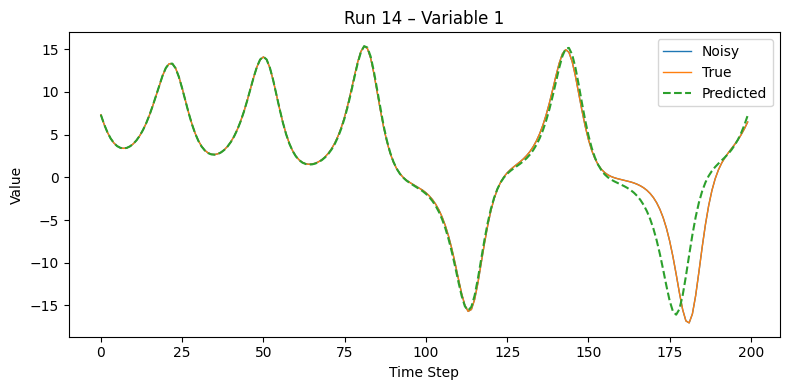

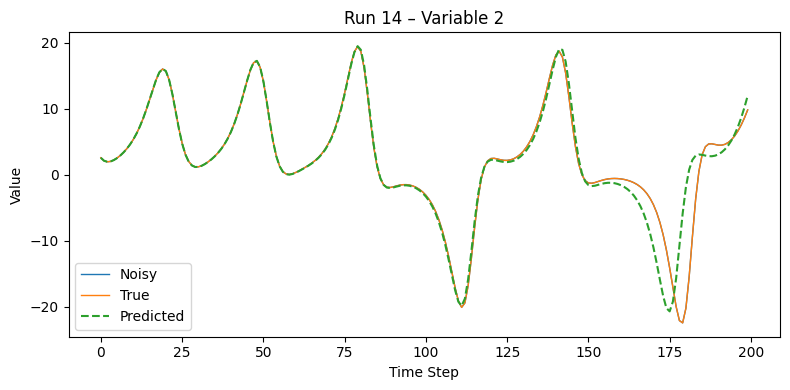

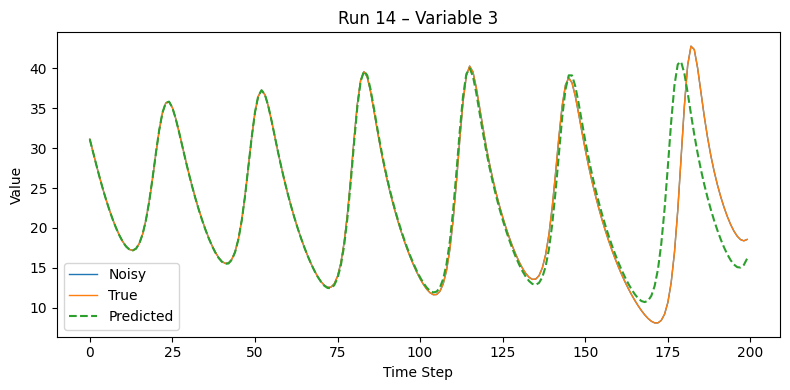

[Adam] Epoch   0 | Loss: 2.5967e+01
[Adam] Epoch 1000 | Loss: 2.9734e-03
[Adam] Epoch 1999 | Loss: 9.8487e-03
[L-BFGS] Epoch   0 | Loss: 3.8406e-03
[L-BFGS] Epoch 100 | Loss: 4.0675e-06
[L-BFGS] Epoch 200 | Loss: 2.7720e-06
Early stopping triggered at epoch 200
Final model saved after L-BFGS fine-tuning.


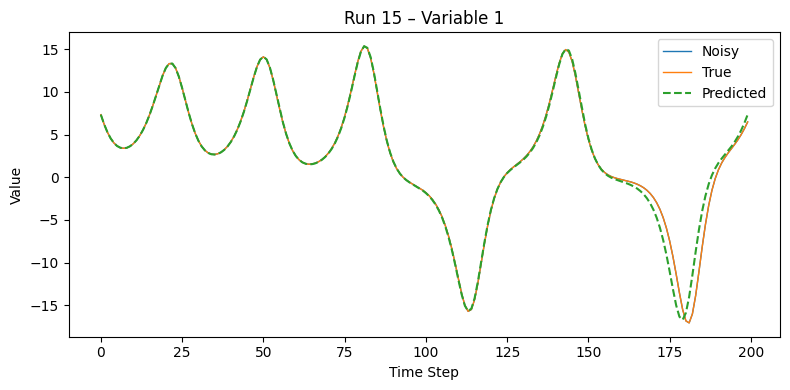

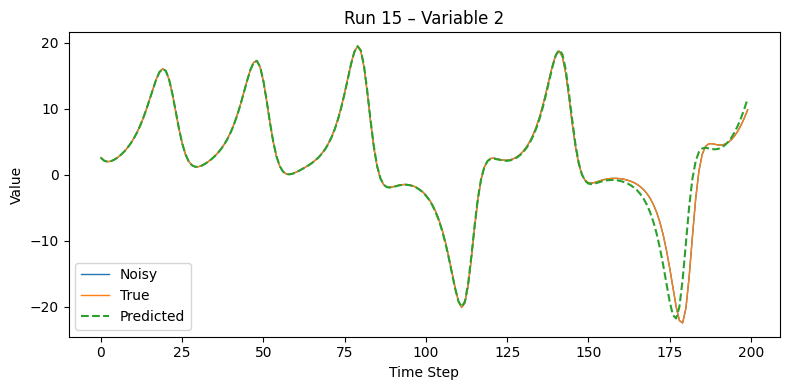

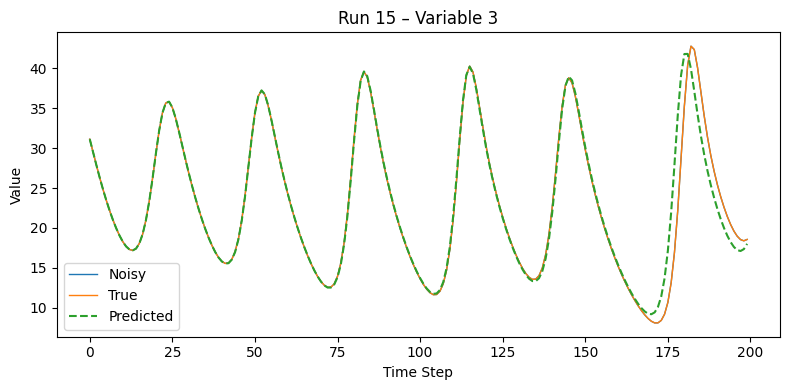

[Adam] Epoch   0 | Loss: 2.1396e+01
[Adam] Epoch 1000 | Loss: 9.3080e-04
[Adam] Epoch 1999 | Loss: 2.3893e-04
[L-BFGS] Epoch   0 | Loss: 2.5916e-04
[L-BFGS] Epoch 100 | Loss: 3.2024e-06
Early stopping triggered at epoch 168
Final model saved after L-BFGS fine-tuning.


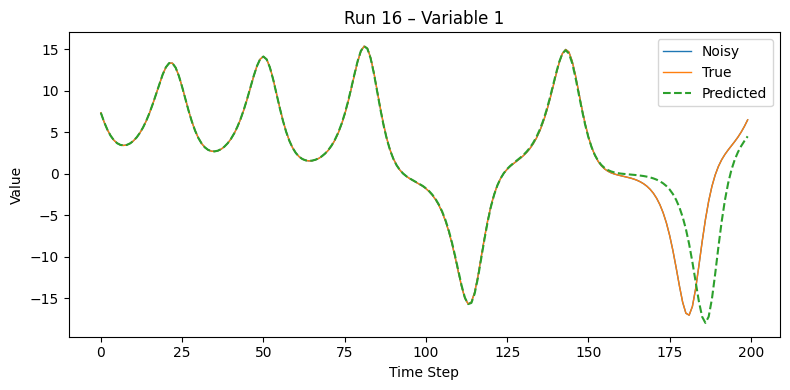

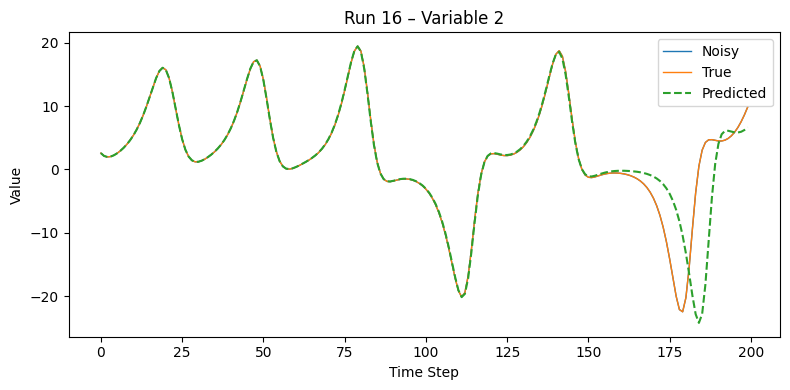

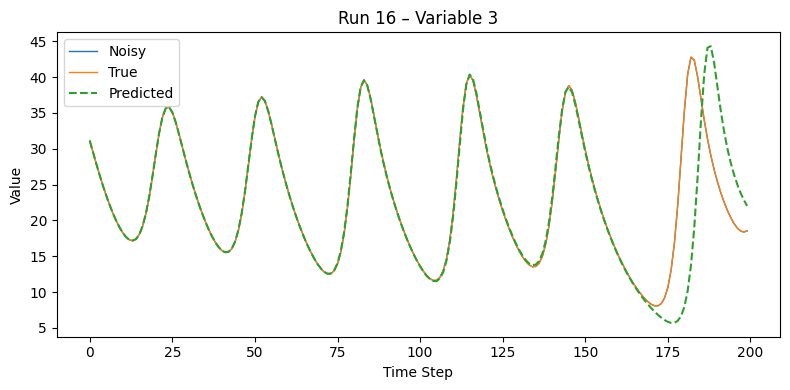

[Adam] Epoch   0 | Loss: 1.2444e+01
[Adam] Epoch 1000 | Loss: 2.3797e-03
[Adam] Epoch 1999 | Loss: 1.2599e-04
[L-BFGS] Epoch   0 | Loss: 1.3103e-04
[L-BFGS] Epoch 100 | Loss: 4.2272e-06
Early stopping triggered at epoch 146
Final model saved after L-BFGS fine-tuning.


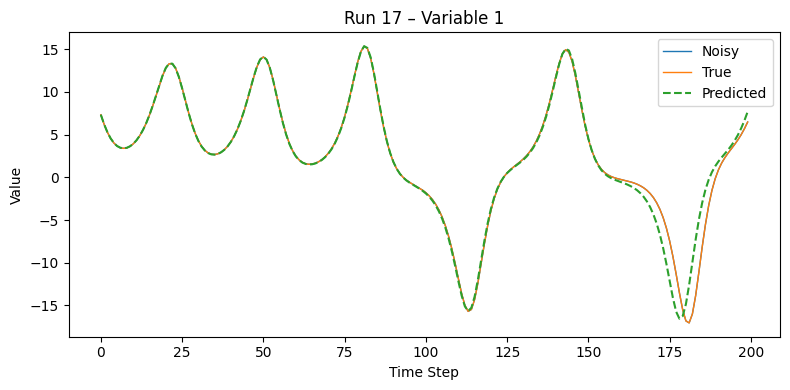

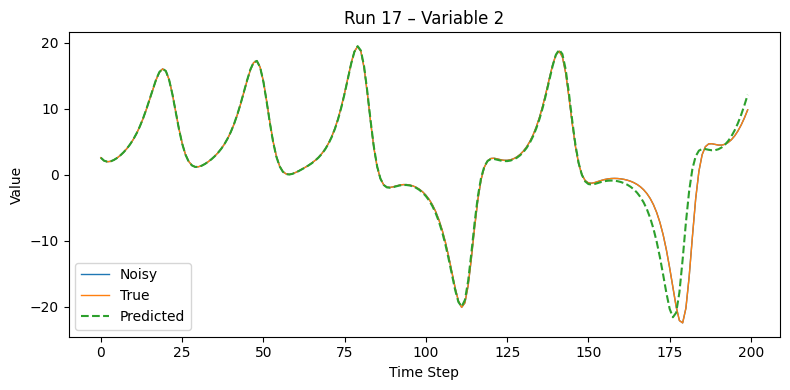

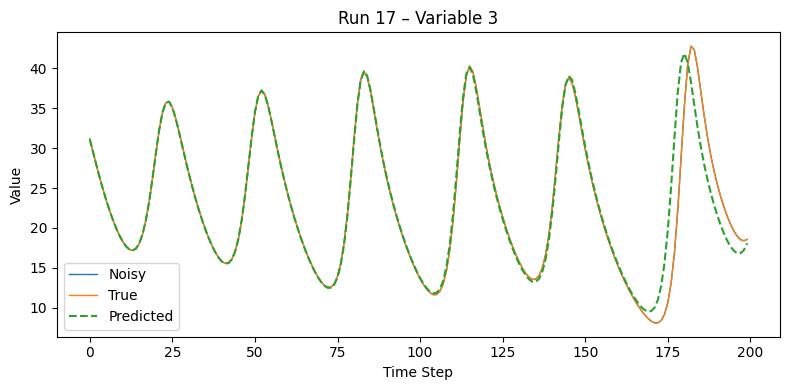

[Adam] Epoch   0 | Loss: 5.4077e+01
[Adam] Epoch 1000 | Loss: 9.2304e-04
[Adam] Epoch 1999 | Loss: 1.6183e-04
[L-BFGS] Epoch   0 | Loss: 1.6116e-04
[L-BFGS] Epoch 100 | Loss: 3.1552e-06
Early stopping triggered at epoch 150
Final model saved after L-BFGS fine-tuning.


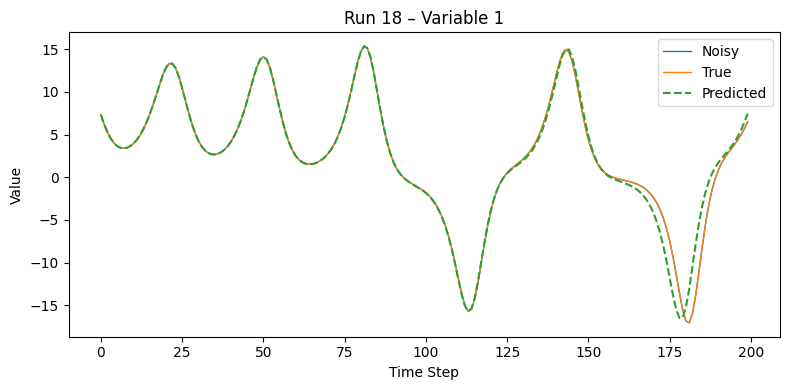

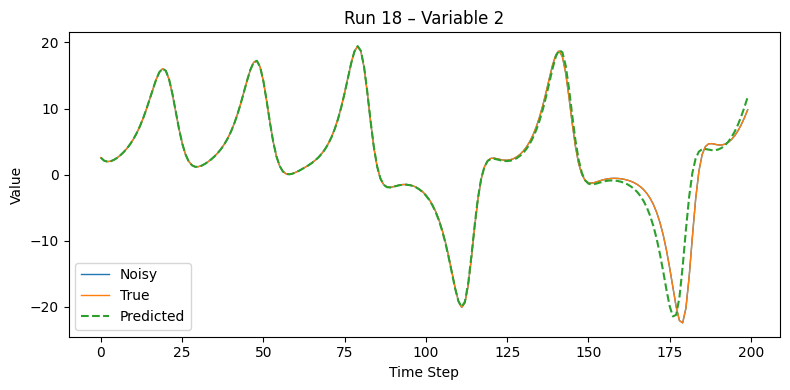

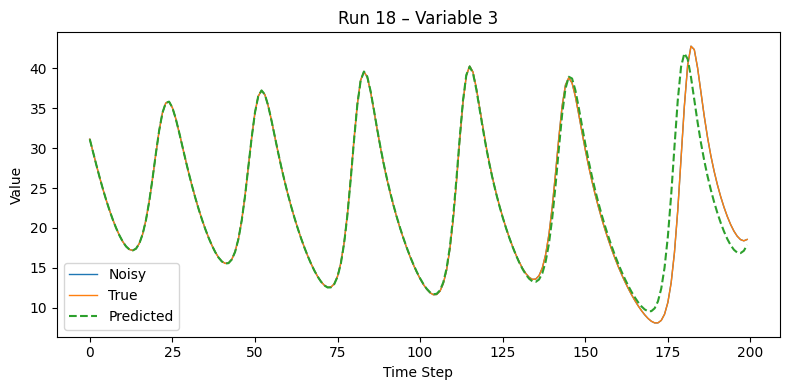

[Adam] Epoch   0 | Loss: 1.2582e+01
[Adam] Epoch 1000 | Loss: 2.6570e-04
[Adam] Epoch 1999 | Loss: 1.6280e-04
[L-BFGS] Epoch   0 | Loss: 2.1350e-04
[L-BFGS] Epoch 100 | Loss: 3.6518e-06
Early stopping triggered at epoch 161
Final model saved after L-BFGS fine-tuning.


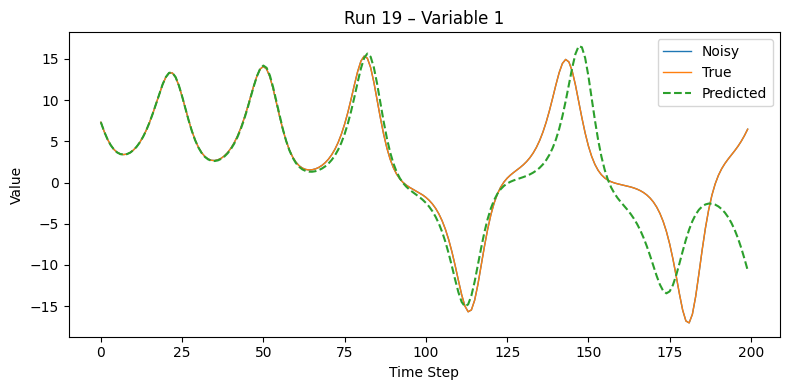

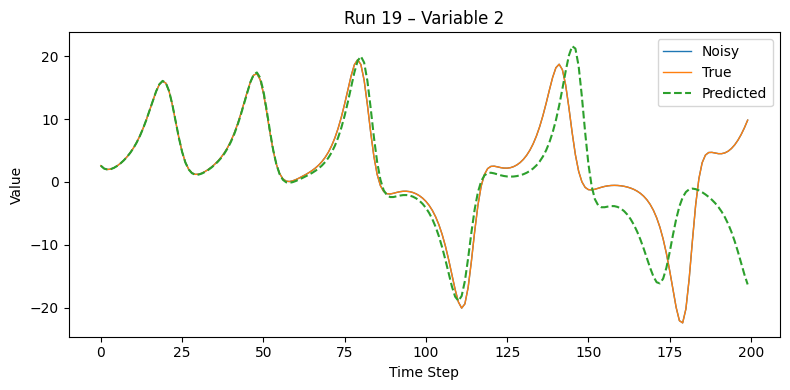

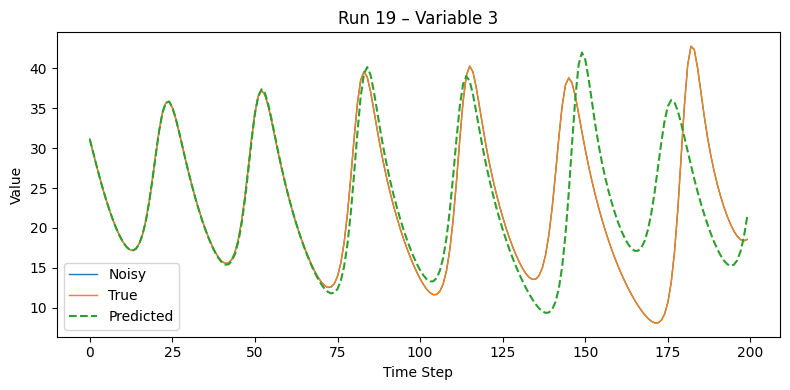

[Adam] Epoch   0 | Loss: 2.7794e+01
[Adam] Epoch 1000 | Loss: 5.8591e-03
[Adam] Epoch 1999 | Loss: 2.7917e-04
[L-BFGS] Epoch   0 | Loss: 2.7694e-04
[L-BFGS] Epoch 100 | Loss: 3.4747e-06
Early stopping triggered at epoch 144
Final model saved after L-BFGS fine-tuning.


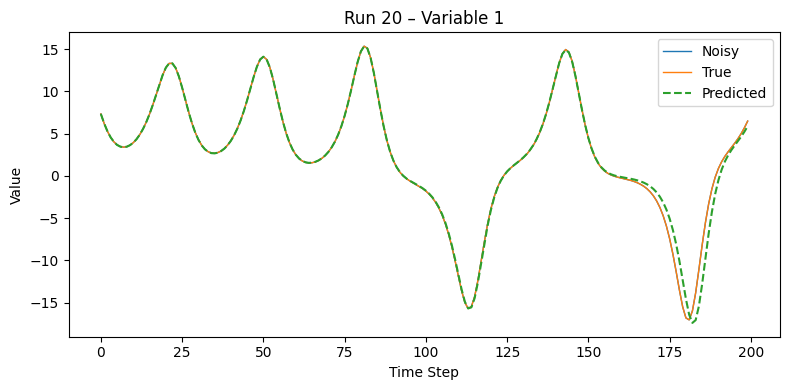

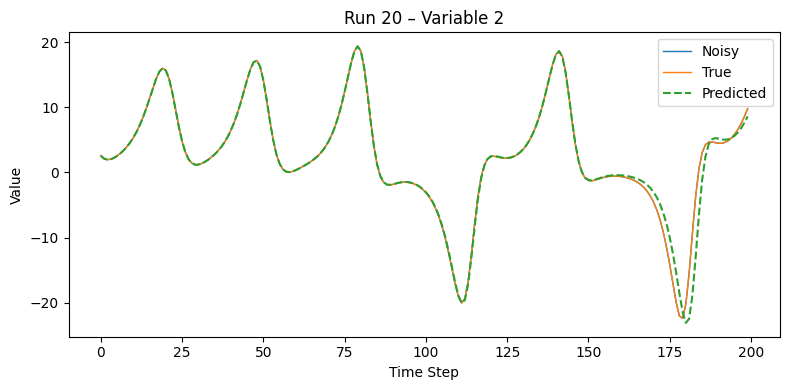

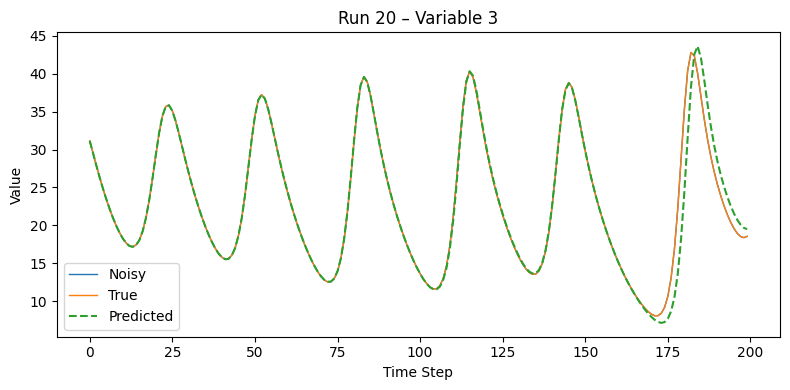

[Adam] Epoch   0 | Loss: 2.1408e+01
[Adam] Epoch 1000 | Loss: 7.7027e-04
[Adam] Epoch 1999 | Loss: 2.6887e-03
[L-BFGS] Epoch   0 | Loss: 5.9697e-03
[L-BFGS] Epoch 100 | Loss: 3.3881e-06
Early stopping triggered at epoch 165
Final model saved after L-BFGS fine-tuning.


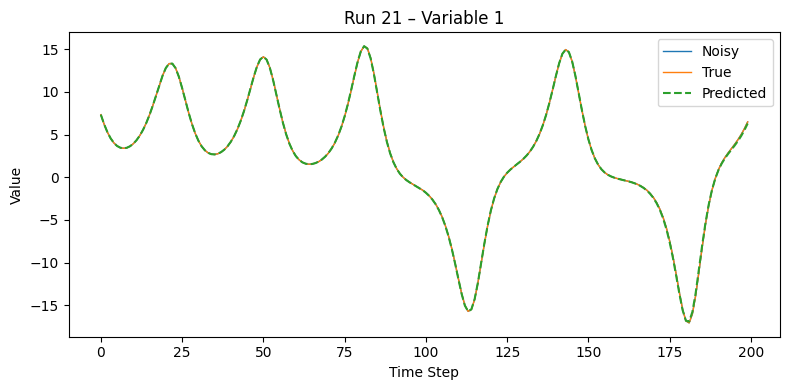

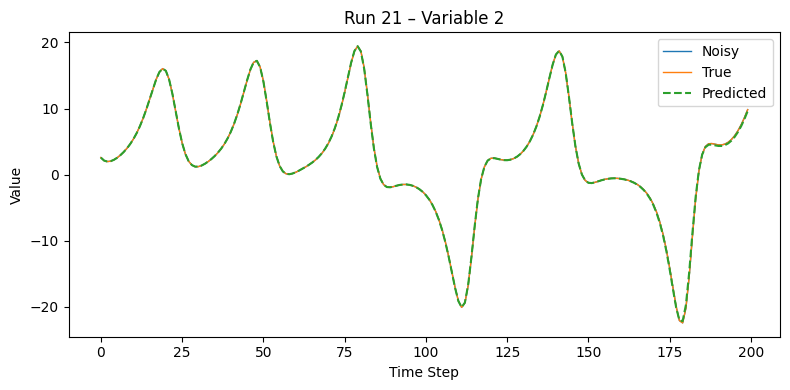

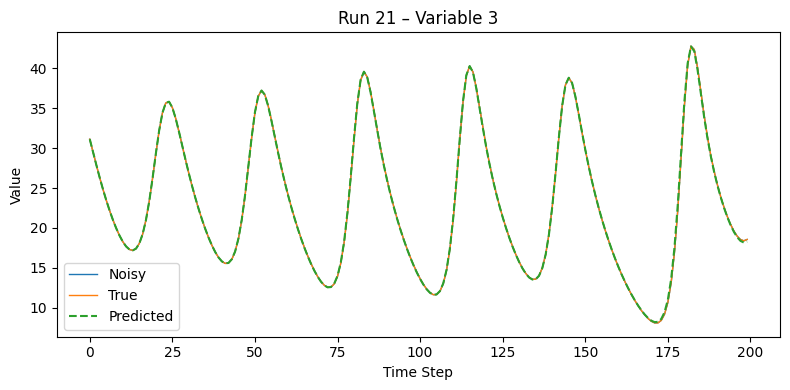

[Adam] Epoch   0 | Loss: 1.5287e+01
[Adam] Epoch 1000 | Loss: 3.5037e-04
[Adam] Epoch 1999 | Loss: 8.2768e-04
[L-BFGS] Epoch   0 | Loss: 7.6379e-04
[L-BFGS] Epoch 100 | Loss: 3.9621e-06
Early stopping triggered at epoch 169
Final model saved after L-BFGS fine-tuning.


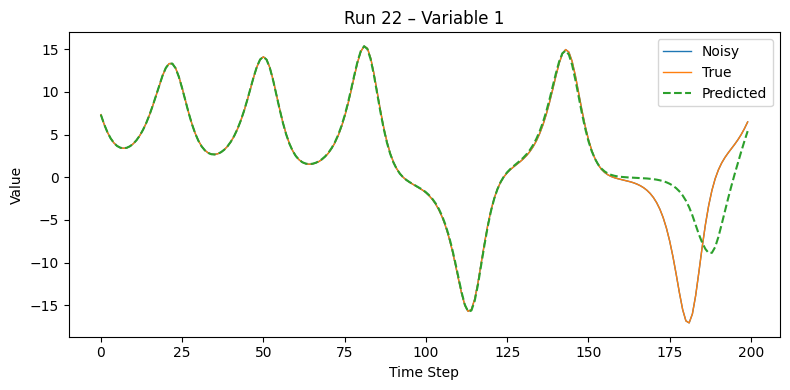

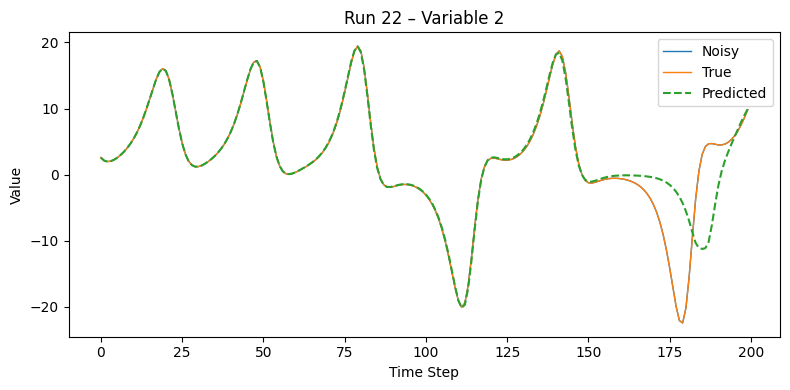

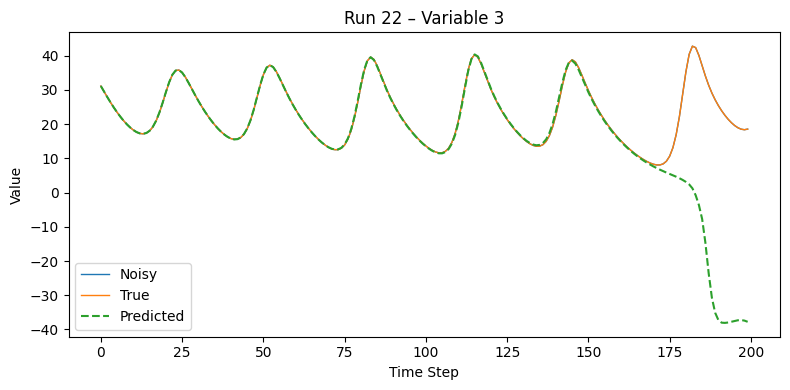

[Adam] Epoch   0 | Loss: 3.1467e+01
[Adam] Epoch 1000 | Loss: 5.2362e-04
[Adam] Epoch 1999 | Loss: 3.4441e-03
[L-BFGS] Epoch   0 | Loss: 3.8501e-03
[L-BFGS] Epoch 100 | Loss: 3.4590e-06
Early stopping triggered at epoch 167
Final model saved after L-BFGS fine-tuning.


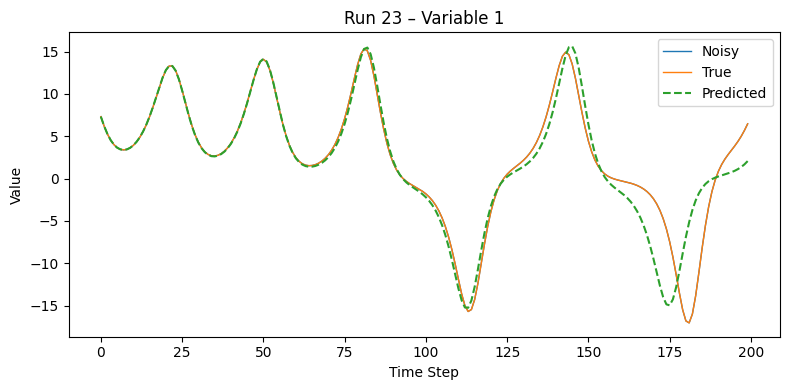

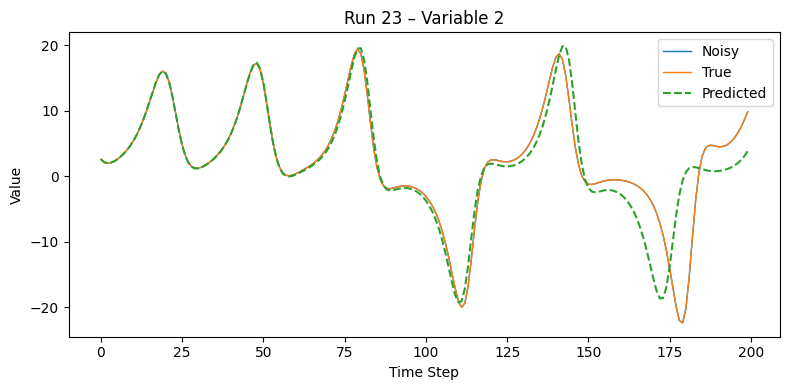

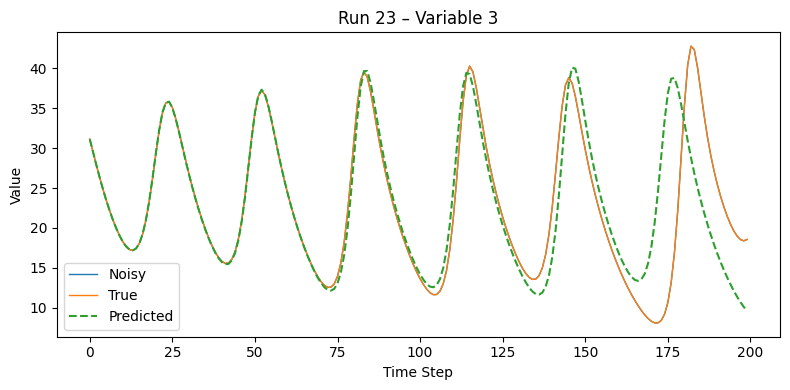

[Adam] Epoch   0 | Loss: 2.9036e+01
[Adam] Epoch 1000 | Loss: 2.4000e-04
[Adam] Epoch 1999 | Loss: 3.2862e-04
[L-BFGS] Epoch   0 | Loss: 3.2141e-04
[L-BFGS] Epoch 100 | Loss: 3.2586e-06
Early stopping triggered at epoch 154
Final model saved after L-BFGS fine-tuning.


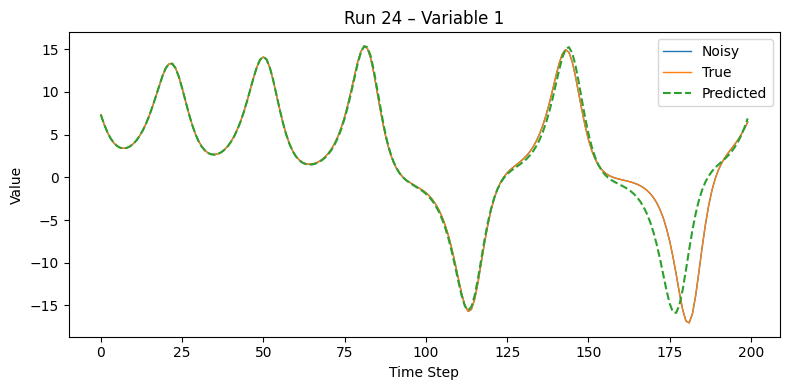

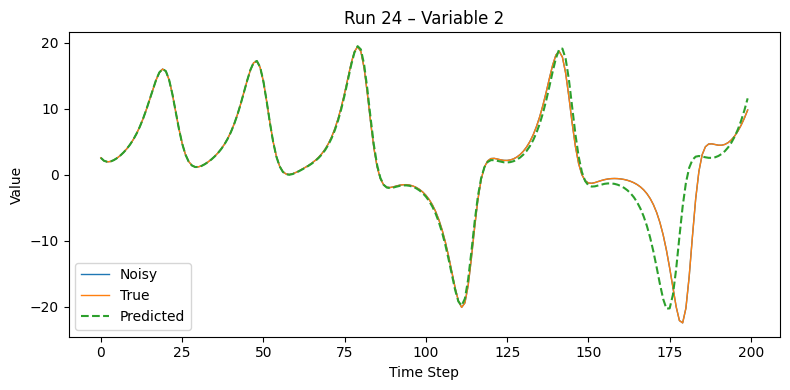

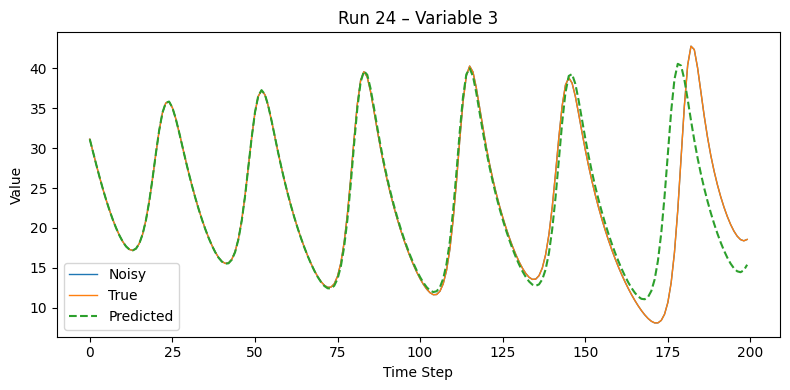

[Adam] Epoch   0 | Loss: 1.7339e+01
[Adam] Epoch 1000 | Loss: 9.4933e-04
[Adam] Epoch 1999 | Loss: 1.1289e-04
[L-BFGS] Epoch   0 | Loss: 1.1229e-04
[L-BFGS] Epoch 100 | Loss: 4.2484e-06
Early stopping triggered at epoch 172
Final model saved after L-BFGS fine-tuning.


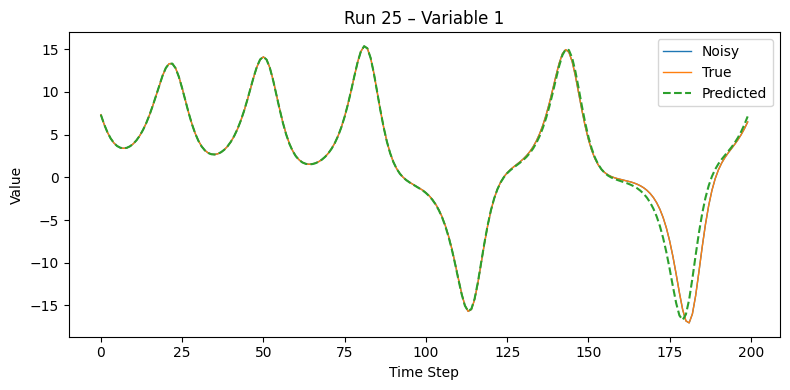

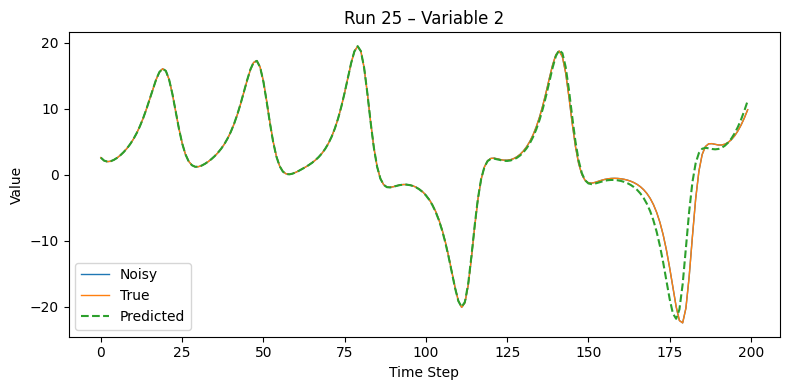

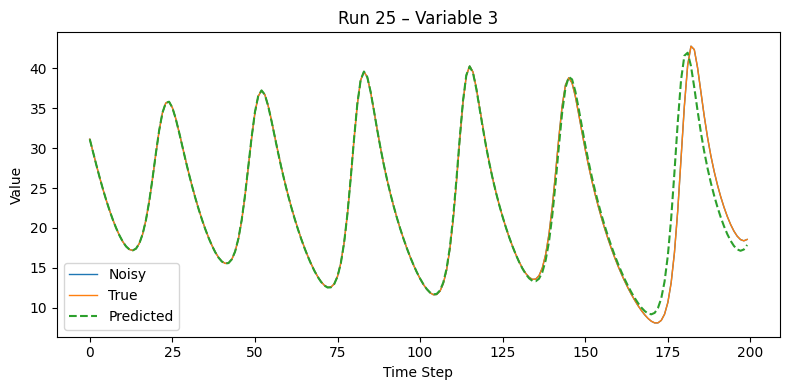


RMSE over 25 time steps:
Variable 1: 0.007472 ± 0.004176
Variable 2: 0.014571 ± 0.008196
Variable 3: 0.018850 ± 0.009553

RMSE over 50 time steps:
Variable 1: 0.017417 ± 0.010812
Variable 2: 0.025125 ± 0.016477
Variable 3: 0.038652 ± 0.026578

RMSE over 75 time steps:
Variable 1: 0.039314 ± 0.046394
Variable 2: 0.062605 ± 0.076876
Variable 3: 0.049783 ± 0.042757

RMSE over 100 time steps:
Variable 1: 0.080171 ± 0.116044
Variable 2: 0.125228 ± 0.182992
Variable 3: 0.158433 ± 0.233672


In [8]:
warnings.filterwarnings("ignore", category=FutureWarning)

base_seed = 2025
num_runs = 25

rmse_runs25 = []
rmse_runs50 = []
rmse_runs75 = []
rmse_runs100 = []

for i in range(num_runs):
    seed = base_seed + i
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    AdaptiveNVARmodel = train_joint_model_with_lbfgs(X_train, k=k, m=m)
    
    model = AdaptiveNVARModel(dk=dk, m=m, d=d).to(device)
    model.load_state_dict(torch.load("best_joint_model_0percent_noise.pth"))
    model.eval()

    # Prepare test data
    H_test = construct_H_lin(X_test, k)
    y_test = X_test[k:] - X_test[k - 1:-1]

    # Auto-regressive prediction loop
    X_init = X_train[-k:]
    x_t = [x.clone() for x in X_init.unbind(0)]
    H_lin = torch.cat(x_t, dim=-1).unsqueeze(0)
    predictions = []

    num_steps = len(X_test)
    for t in range(num_steps):
        with torch.no_grad():
            delta_x = model(H_lin)
        x_t_next = x_t[-1] + delta_x.squeeze(0)
        predictions.append(x_t_next)
        x_t = x_t[1:] + [x_t_next]
        H_lin = torch.cat(x_t, dim=-1).unsqueeze(0)

    predictions_np = torch.stack(predictions).detach().cpu().numpy()
    X_test_np = X_test.detach().cpu().numpy()
    X_test_true_np = X_test_true.detach().cpu().numpy()

    # ----- PLOTTING SECTION -----
    import matplotlib.pyplot as plt
    X_test_trimmed = X_test_np[:len(predictions_np)]
    X_test_true_trimmed = X_test_true_np[:len(predictions_np)]
    num_vars = predictions_np.shape[1]
    time = np.arange(len(predictions_np))

    for var_idx in range(num_vars):
        plt.figure(figsize=(8, 4))
        plt.plot(time, X_test_trimmed[:, var_idx], label='Noisy', linewidth=1)
        plt.plot(time, X_test_true_trimmed[:, var_idx], label='True', linewidth=1)
        plt.plot(time, predictions_np[:, var_idx], label='Predicted', linestyle='--')
        plt.title(f'Run {i+1} – Variable {var_idx + 1}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.tight_layout()
        plt.show()
    # ----------------------------

    # Compute RMSE for various horizons
    rmse_25 = np.sqrt(np.mean((X_test_true_np[:25] - predictions_np[:25])**2, axis=0))
    rmse_50 = np.sqrt(np.mean((X_test_true_np[:50] - predictions_np[:50])**2, axis=0))
    rmse_75 = np.sqrt(np.mean((X_test_true_np[:75] - predictions_np[:75])**2, axis=0))
    rmse_100 = np.sqrt(np.mean((X_test_true_np[:100] - predictions_np[:100])**2, axis=0))

    rmse_runs25.append(rmse_25)
    rmse_runs50.append(rmse_50)
    rmse_runs75.append(rmse_75)
    rmse_runs100.append(rmse_100)

# --------- Aggregating RMSE ---------
def compute_rmse_stats(rmse_runs):
    arr = np.array(rmse_runs)
    return arr.mean(axis=0), arr.std(axis=0)

rmse_mean25, rmse_std25 = compute_rmse_stats(rmse_runs25)
rmse_mean50, rmse_std50 = compute_rmse_stats(rmse_runs50)
rmse_mean75, rmse_std75 = compute_rmse_stats(rmse_runs75)
rmse_mean100, rmse_std100 = compute_rmse_stats(rmse_runs100)

# ---------- Print RMSE ----------
def print_rmse(label, mean, std):
    print(f"\nRMSE over {label} time steps:")
    for i in range(len(mean)):
        print(f"Variable {i+1}: {mean[i]:.6f} ± {std[i]:.6f}")

print_rmse(25, rmse_mean25, rmse_std25)
print_rmse(50, rmse_mean50, rmse_std50)
print_rmse(75, rmse_mean75, rmse_std75)
print_rmse(100, rmse_mean100, rmse_std100)